# Decision Analytics for Business and Policy
## Group Project
### Ashwin Kandath, Gareth Minson-Efimov, and Raj Shah

# Packages

In [ ]:
import gurobipy as gp
from gurobipy import GRB
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import geopandas as gpd
import geoplot.crs as gcrs
import geoplot as gplt
import matplotlib.patches as mpatches
from matplotlib.colors import LinearSegmentedColormap


# Import data

In [2]:
data = pd.read_csv('2026_full_data.csv')
geo = gpd.read_file('relevant_precincts.geojson')

In [ ]:
# Total Precincts and Features
data.shape

(1132, 170)

In [4]:
# Total Expected Voters
data.iloc[:,26:].sum().sum()

469885

# Priority Model
Optimize voting booth and check-in station allocation across all precincts without exceeding the budget for each. Include a higher lower bound for voting booths in priority precincts.

In [ ]:
time_periods = data.columns[26:].values
num_time_periods = len(time_periods)
precinct_num = data.shape[0]

clusters = data['cluster'].values

cluster_dict = {0: 3, 1: 5, 2:3, 3:5, 4:5, 5:3}

arrival_rates = data.iloc[:, 26:].values

# 2.5 voters per 5-minute period
service_rate_check_in = 30/12

# 5 voters per 5-minute period
service_rate_voting = 60/12

total_check_in_stations = precinct_num * 3
total_voting_booths = precinct_num * 9

model = gp.Model("MinimizeQueueWaiting")

max_check_in_stations = 5
max_voting_booths = 10


C = model.addVars(precinct_num, vtype=GRB.INTEGER, lb=2, ub=max_check_in_stations, name="CheckInStations")
V = model.addVars(precinct_num, vtype=GRB.INTEGER, lb=3, ub=max_voting_booths, name="VotingBooths")
W_checkin = model.addVars(precinct_num, num_time_periods, vtype=GRB.INTEGER, lb=0, name="CheckInQueue")
W_voting = model.addVars(precinct_num, num_time_periods, vtype=GRB.INTEGER, lb=0, name="VotingQueue")

# Constraints

for i in range(precinct_num):
    service_capacity = C[i] * service_rate_check_in
    model.addConstr(
        W_checkin[i, 0] >= arrival_rates[i, 0] - service_capacity,
        name=f"InitialQueue_{i}"
    )
    model.addConstr(
        W_checkin[i, 0] >= 0,
        name=f"NonNegativeQueue_{i}_0"
    )

    model.addConstr(
        W_voting[i, 0] >= 0,
        name=f"NonNegativeVotingQueue_{i}"
    )

    min_booth_voting = cluster_dict[clusters[i]]
    model.addConstr(
        V[i] >= min_booth_voting,
        name=f"MinVotingBooths_{i}"
    )


for i in range(precinct_num):
    for t in range(1, num_time_periods):
        service_capacity_checkin = C[i] * service_rate_check_in
        model.addConstr(
            W_checkin[i, t] >= W_checkin[i, t-1] + arrival_rates[i, t] - service_capacity_checkin,
            name=f"QueueDynamics_{i}_{t}"
        )
        model.addConstr(
            W_checkin[i, t] >= 0,
            name=f"NonNegativeQueue_{i}_{t}"
        )

        service_capacity_voting = V[i] * service_rate_voting
        model.addConstr(
            W_voting[i, t] >= W_voting[i, t-1] + (W_checkin[i,t-1]) - service_capacity_voting,
            name=f"VotingQueueDynamics_{i}_{t}"
        )
        model.addConstr(
            W_voting[i, t] >= 0,
            name=f"NonNegativeVotingQueue_{i}_{t}"
        )

model.addConstr(
    gp.quicksum(C[i] for i in range(precinct_num)) <= total_check_in_stations,
    name="TotalCheckInStations"
)
model.addConstr(
    gp.quicksum(V[i] for i in range(precinct_num)) <= total_voting_booths,
    name="TotalVotingBooths"
)

model.setObjective(
    gp.quicksum(W_checkin[i, t] for i in range(precinct_num) for t in range(num_time_periods))+ \
        gp.quicksum(W_voting[i, t] for i in range(precinct_num) for t in range(num_time_periods)),
    GRB.MINIMIZE
)

model.setParam('OutputFlag', 1)
model.setParam('MIPGap', 0.01)

model.optimize()

columns = ['precinct', 'check_in', 'voting', 'checkin_stations', 'voting_stations']
prec = []
check_in = []
voting = []
checkin_stations = []
voting_stations = []

if model.status == GRB.OPTIMAL:
    print("Optimal solution found!")
    for i in range(precinct_num):
        prec.append(i)
        check_in_val = int(C[i].x)
        voting_val = int(V[i].x)
        queue_sizes_checkin = [W_checkin[i, t].x for t in range(num_time_periods)]
        queue_sizes_voting = [W_voting[i, t].x for t in range(num_time_periods)]
        check_in.append(sum(queue_sizes_checkin))
        voting.append(sum(queue_sizes_voting))
        checkin_stations.append(check_in_val)
        voting_stations.append(voting_val)
        
        # print(f"Precinct {i}: {check_in} check-in stations, {voting} voting booths")
        # print(f"Check-in Queue sizes per time period: {queue_sizes_checkin}")
        # print(f"Voting queue sizes per time period: {queue_sizes_voting}")
        # print("Queue check-in:", sum(queue_sizes_checkin))
        print("Queue voting:", sum(queue_sizes_voting)+sum(queue_sizes_checkin))
        print("Average Queue:", np.mean(queue_sizes_checkin), np.mean(queue_sizes_voting))
else:
    print("No optimal solution found. Status code:", model.status)
    if model.status == GRB.INFEASIBLE:
        print("Model is infeasible. Computing IIS (Irreducible Inconsistent Subsystem)...")
        model.computeIIS()
        model.write("model.ilp")
        print("IIS written to 'model.ilp'")

Set parameter Username
Academic license - for non-commercial use only - expires 2025-08-30
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11.0 (22631.2))

CPU model: 13th Gen Intel(R) Core(TM) i7-1360P, instruction set [SSE2|AVX|AVX2]
Thread count: 12 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 652034 rows, 328280 columns and 1464808 nonzeros
Model fingerprint: 0xfe919320
Variable types: 0 continuous, 328280 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 5e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [2e+00, 1e+01]
  RHS range        [1e+00, 1e+04]
Presolve removed 571755 rows and 246601 columns
Presolve time: 0.75s
Presolved: 80279 rows, 81679 columns, 241434 nonzeros
Variable types: 0 continuous, 81679 integer (2471 binary)
Deterministic concurrent LP optimizer: primal and dual simplex
Showing primal log only...

Concurrent spin time: 0.00s

Solved with d

## Priority Model Minimized Total Waiting Periods Result
1% Tolerance

In [6]:
model.objVal

627005.0

## Priority Model Results

In [7]:
results = pd.DataFrame({'prec': prec,
              'check_in': check_in,
                'voting':voting,
                "checkin_stations": checkin_stations,
                "voting_stations": voting_stations})
results['district'] = data['district']
results['cluster'] = data['cluster']
results['total wait'] = results['check_in'] + results['voting']
results.to_csv('results.csv')

## Priority Model Charts

In [8]:
geo_wait = geo.merge(results, on = 'district', how = 'left')
# geo_wait['cluster'] = geo_wait['cluster'].astype('category')

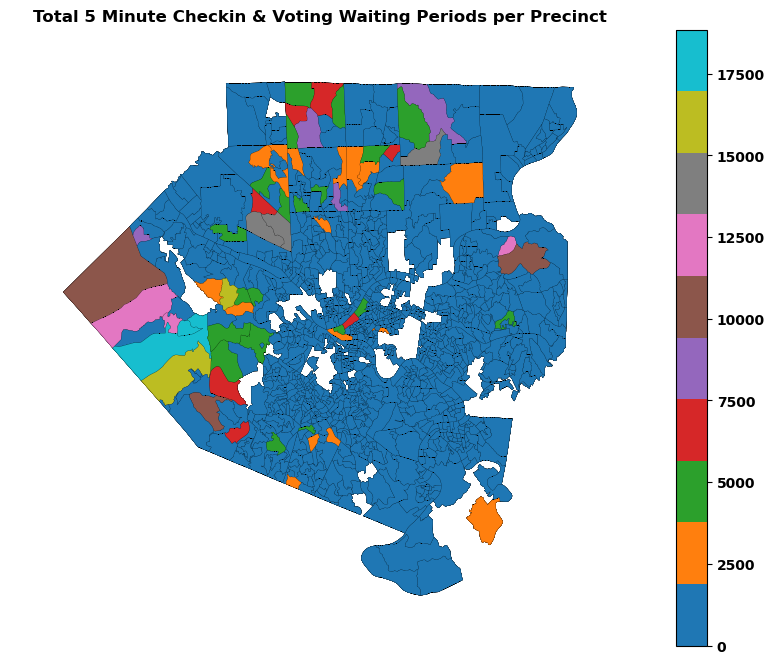

In [9]:

gplt.choropleth(
    geo_wait,
    projection=gcrs.AlbersEqualArea(),
    hue="total wait", cmap='tab10',
    linewidth=.1,
    legend = True,
    edgecolor='black',
    figsize=(12, 8)
)
plt.title("Total 5 Minute Checkin & Voting Waiting Periods per Precinct")
plt.show()

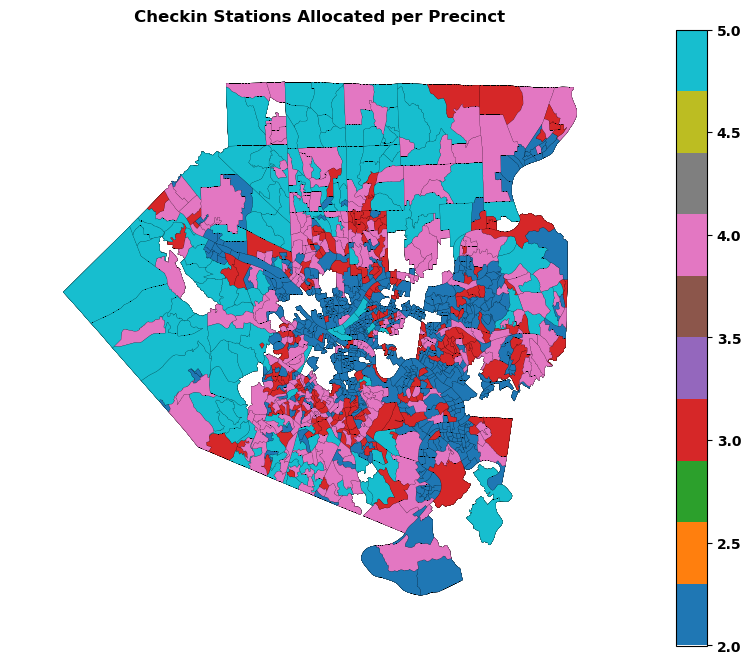

In [10]:
gplt.choropleth(
    geo_wait,
    projection=gcrs.AlbersEqualArea(),
    hue="checkin_stations", cmap='tab10',
    linewidth=.1,
    legend = True,
    edgecolor='black',
    figsize=(12, 8)
)
plt.title("Checkin Stations Allocated per Precinct")
plt.show()

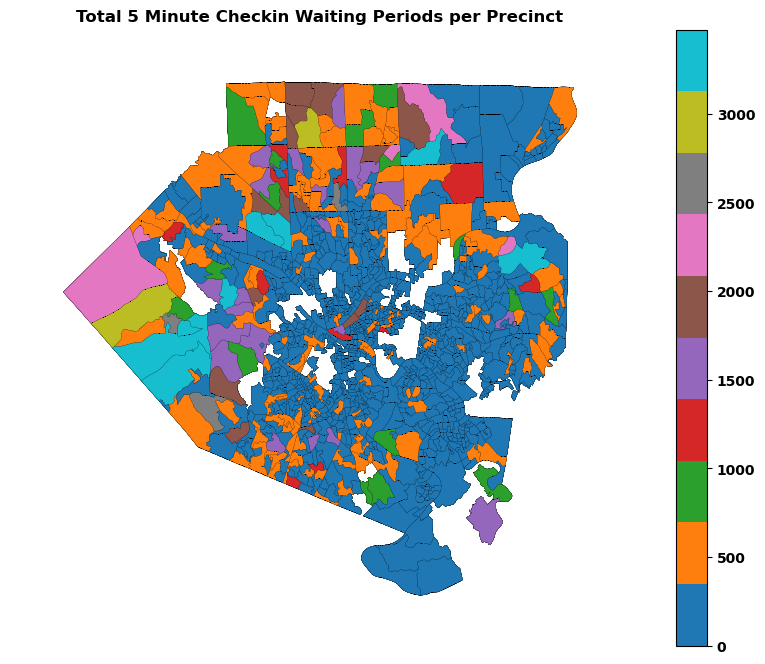

In [11]:
gplt.choropleth(
    geo_wait,
    projection=gcrs.AlbersEqualArea(),
    hue="check_in", cmap='tab10',
    linewidth=.1,
    legend = True,
    edgecolor='black',
    figsize=(12, 8)
)
plt.title("Total 5 Minute Checkin Waiting Periods per Precinct")
plt.show()

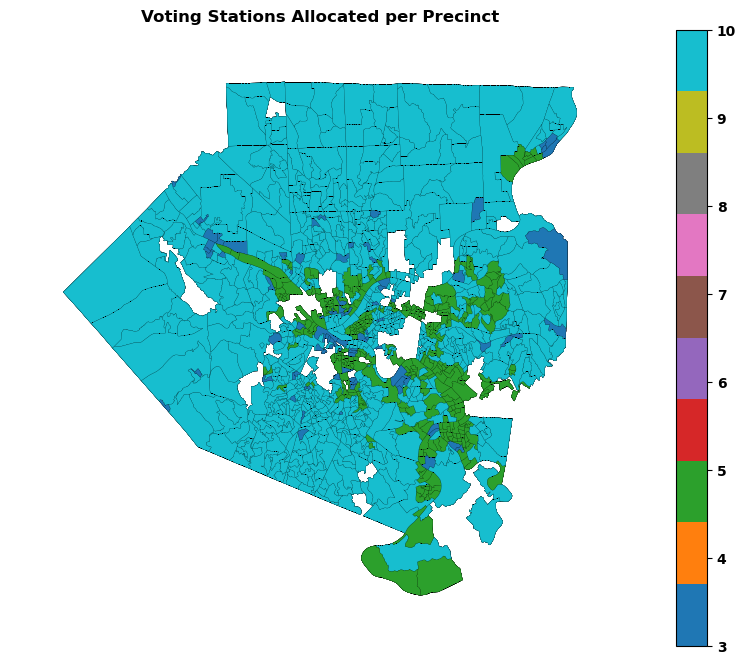

In [12]:
gplt.choropleth(
    geo_wait,
    projection=gcrs.AlbersEqualArea(),
    hue="voting_stations", cmap='tab10',
    linewidth=.1,
    legend = True,
    edgecolor='black',
    figsize=(12, 8)
)
plt.title("Voting Stations Allocated per Precinct")
plt.show()

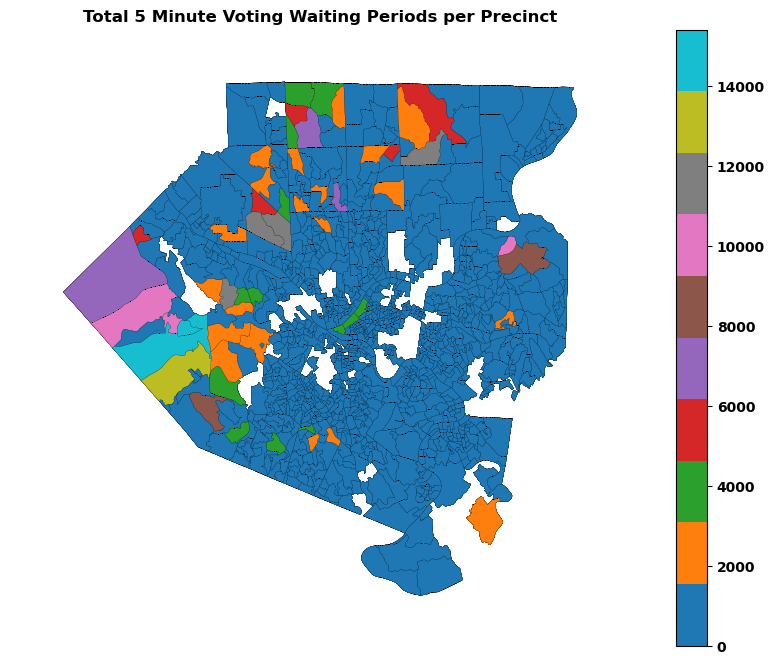

In [13]:
# inferno_r
gplt.choropleth(
    geo_wait,
    projection=gcrs.AlbersEqualArea(),
    hue="voting", cmap='tab10',
    linewidth=.1,
    legend = True,
    edgecolor='black',
    figsize=(12, 8)
)
plt.title("Total 5 Minute Voting Waiting Periods per Precinct")
plt.show()

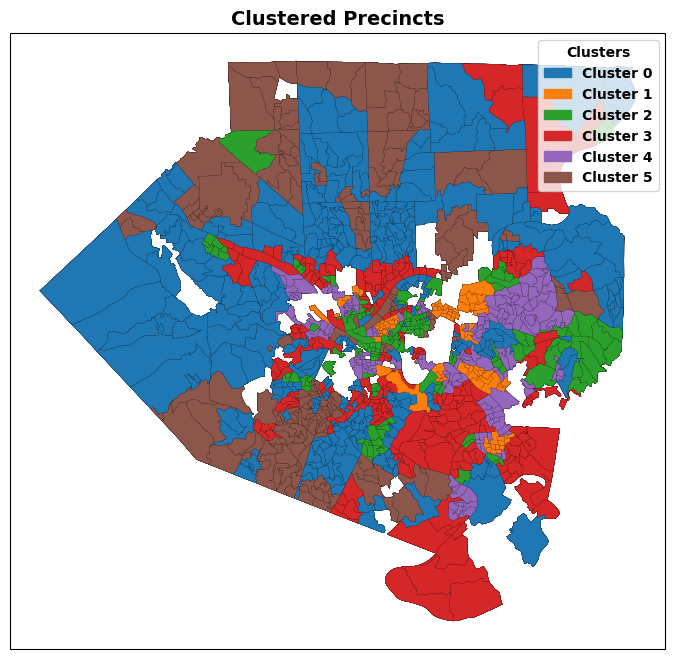

In [14]:
cmap = plt.get_cmap('tab10')
cluster_colors = {i: cmap(i) for i in range(6)}
geo_wait['color'] = geo_wait['cluster'].map(cluster_colors)

fig, ax = plt.subplots(figsize=(12, 8), subplot_kw={'projection': gcrs.AlbersEqualArea()})
geo_wait.plot(
    color=geo_wait['color'],
    edgecolor='black',
    linewidth=0.1,
    ax=ax
)

legend_labels = [f"Cluster {i}" for i in range(6)]
handles = [mpatches.Patch(color=cluster_colors[i], label=legend_labels[i]) for i in range(6)]

plt.legend(
    handles=handles,
    title="Clusters",
    loc="upper right",
    frameon=True
)

plt.title("Clustered Precincts", fontsize=14)
plt.show()

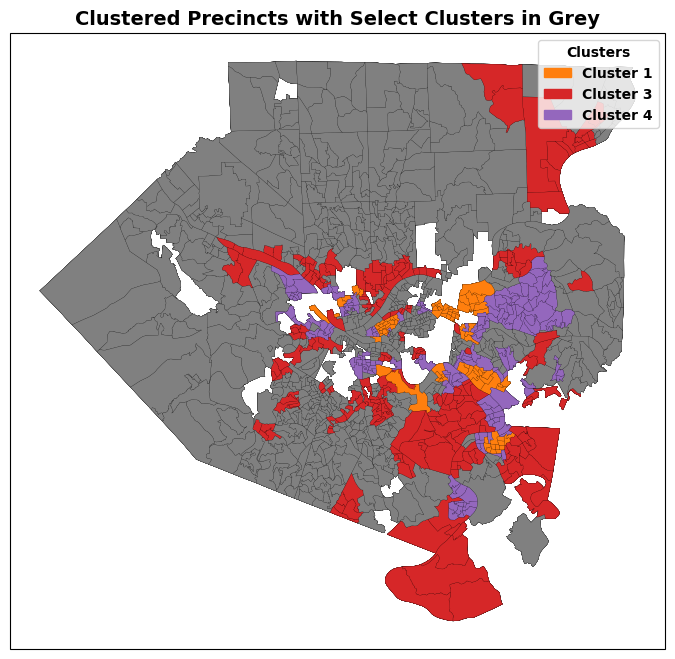

In [15]:
cmap = plt.get_cmap('tab10')
default_colors = {i: cmap(i) for i in range(6)}  

cluster_colors = default_colors.copy()
for cluster in [0, 2, 5]:
    cluster_colors[cluster] = "grey"

geo_wait['color'] = geo_wait['cluster'].map(cluster_colors)

fig, ax = plt.subplots(figsize=(12, 8), subplot_kw={'projection': gcrs.AlbersEqualArea()})
geo_wait.plot(
    color=geo_wait['color'],
    edgecolor='black',
    linewidth=0.1,
    ax=ax
)

handles = [
    mpatches.Patch(color=cluster_colors[i], label=f"Cluster {i}")
    for i in range(6)
    if i not in [0, 2, 5]
]

plt.legend(
    handles=handles,
    title="Clusters",
    loc="upper right",
    frameon=True
)

plt.title("Clustered Precincts with Select Clusters in Grey", fontsize=14)
plt.show()

# Neutral Model
A secondary model that allows comparison to the same optimization process, but without any difference in minimum resource allocation across precincts.

In [ ]:
model.reset()

time_periods = data.columns[26:].values
num_time_periods = len(time_periods)
precinct_num = data.shape[0]

clusters = data['cluster'].values

cluster_dict = {0: 3, 1: 5, 2:3, 3:5, 4:5, 5:3}

arrival_rates = data.iloc[:, 26:].values

service_rate_check_in = 30/12
service_rate_voting = 60/12

total_check_in_stations = precinct_num * 3
total_voting_booths = precinct_num * 9

model = gp.Model("MinimizeQueueWaiting")

max_check_in_stations = 5
max_voting_booths = 10

C = model.addVars(precinct_num, vtype=GRB.INTEGER, lb=2, ub=max_check_in_stations, name="CheckInStations")
V = model.addVars(precinct_num, vtype=GRB.INTEGER, lb=3, ub=max_voting_booths, name="VotingBooths")
W_checkin = model.addVars(precinct_num, num_time_periods, vtype=GRB.INTEGER, lb=0, name="CheckInQueue")
W_voting = model.addVars(precinct_num, num_time_periods, vtype=GRB.INTEGER, lb=0, name="VotingQueue")

# Constraints

for i in range(precinct_num):
    service_capacity = C[i] * service_rate_check_in
    model.addConstr(
        W_checkin[i, 0] >= arrival_rates[i, 0] - service_capacity,
        name=f"InitialQueue_{i}"
    )
    model.addConstr(
        W_checkin[i, 0] >= 0,
        name=f"NonNegativeQueue_{i}_0"
    )

    model.addConstr(
        W_voting[i, 0] >= 0,
        name=f"NonNegativeVotingQueue_{i}"
    )

    # min_booth_voting = cluster_dict[clusters[i]]
    # model.addConstr(
    #     V[i] >= min_booth_voting,
    #     name=f"MinVotingBooths_{i}"
    # )


for i in range(precinct_num):
    for t in range(1, num_time_periods):
        service_capacity_checkin = C[i] * service_rate_check_in
        model.addConstr(
            W_checkin[i, t] >= W_checkin[i, t-1] + arrival_rates[i, t] - service_capacity_checkin,
            name=f"QueueDynamics_{i}_{t}"
        )
        model.addConstr(
            W_checkin[i, t] >= 0,
            name=f"NonNegativeQueue_{i}_{t}"
        )

        service_capacity_voting = V[i] * service_rate_voting
        model.addConstr(
            W_voting[i, t] >= W_voting[i, t-1] + (W_checkin[i,t-1]) - service_capacity_voting,
            name=f"VotingQueueDynamics_{i}_{t}"
        )
        model.addConstr(
            W_voting[i, t] >= 0,
            name=f"NonNegativeVotingQueue_{i}_{t}"
        )

model.addConstr(
    gp.quicksum(C[i] for i in range(precinct_num)) <= total_check_in_stations,
    name="TotalCheckInStations"
)
model.addConstr(
    gp.quicksum(V[i] for i in range(precinct_num)) <= total_voting_booths,
    name="TotalVotingBooths"
)

model.setObjective(
    gp.quicksum(W_checkin[i, t] for i in range(precinct_num) for t in range(num_time_periods))+ \
        gp.quicksum(W_voting[i, t] for i in range(precinct_num) for t in range(num_time_periods)),
    GRB.MINIMIZE
)

model.setParam('OutputFlag', 1)
model.setParam('MIPGap', 0.01)

model.optimize()

columns = ['precinct', 'check_in', 'voting', 'checkin_stations', 'voting_stations']
prec_n = []
check_in_n = []
voting_n = []
checkin_stations_n = []
voting_stations_n = []

if model.status == GRB.OPTIMAL:
    print("Optimal solution found!")
    for i in range(precinct_num):
        prec.append(i)
        check_in_val = int(C[i].x)
        voting_val = int(V[i].x)
        queue_sizes_checkin = [W_checkin[i, t].x for t in range(num_time_periods)]
        queue_sizes_voting = [W_voting[i, t].x for t in range(num_time_periods)]
        check_in_n.append(sum(queue_sizes_checkin))
        voting_n.append(sum(queue_sizes_voting))
        checkin_stations_n.append(check_in_val)
        voting_stations_n.append(voting_val)
        
        # print(f"Precinct {i}: {check_in} check-in stations, {voting} voting booths")
        # print(f"Check-in Queue sizes per time period: {queue_sizes_checkin}")
        # print(f"Voting queue sizes per time period: {queue_sizes_voting}")
        # print("Queue check-in:", sum(queue_sizes_checkin))
        # print("Queue voting:", sum(queue_sizes_voting)+sum(queue_sizes_checkin))
        # print("Average Queue:", np.mean(queue_sizes_checkin), np.mean(queue_sizes_voting))
else:
    print("No optimal solution found. Status code:", model.status)
    if model.status == GRB.INFEASIBLE:
        print("Model is infeasible. Computing IIS (Irreducible Inconsistent Subsystem)...")
        model.computeIIS()
        model.write("model.ilp")
        print("IIS written to 'model.ilp'")

Discarded solution information
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11.0 (22631.2))

CPU model: 13th Gen Intel(R) Core(TM) i7-1360P, instruction set [SSE2|AVX|AVX2]
Thread count: 12 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 650902 rows, 328280 columns and 1463676 nonzeros
Model fingerprint: 0x31879405
Variable types: 0 continuous, 328280 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 5e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [2e+00, 1e+01]
  RHS range        [1e+00, 1e+04]
Presolve removed 568768 rows and 244697 columns
Presolve time: 0.68s
Presolved: 82134 rows, 83583 columns, 245840 nonzeros
Variable types: 0 continuous, 83583 integer (2471 binary)
Deterministic concurrent LP optimizer: primal and dual simplex
Showing primal log only...

Concurrent spin time: 0.01s

Solved with dual simplex

Root relaxation: objective 6.014834e+05, 29439 

## Neutral Model Minimized Total Waiting Periods Result
1% Tolerance

In [17]:
model.objVal

627679.0

## Neutral Model Results

In [18]:
results_neutral = pd.DataFrame({
                'check_in_n': check_in_n,
                'voting_n':voting_n,
                "checkin_stations_n": checkin_stations_n,
                "voting_stations_n": voting_stations_n})
results_neutral['total wait_n'] = results_neutral['check_in_n'] + results_neutral['voting_n']

In [19]:
results_2way = pd.concat([results, results_neutral], axis = 1)
results_2way['Dif Checkin'] = results_2way['check_in'] - results_2way['check_in_n']
results_2way['Dif Voting'] = results_2way['voting'] - results_2way['voting_n']
results_2way['Dif Checkin_stations'] = results_2way['checkin_stations'] - results_2way['checkin_stations_n']
results_2way['Dif voting_stations'] = results_2way['voting_stations'] - results_2way['voting_stations_n']
results_2way['Dif Total Wait'] = results_2way['total wait'] - results_2way['total wait_n']
results_2way

,prec,check_in,voting,checkin_stations,voting_stations,district,cluster,total wait,check_in_n,voting_n,checkin_stations_n,voting_stations_n,total wait_n,Dif Checkin,Dif Voting,Dif Checkin_stations,Dif voting_stations,Dif Total Wait
0,0,1470.0,2419.0,5,10,ALEPPO,0,3889.0,1470.0,2419.0,5,10,3889.0,0.0,0.0,0,0,0.0
1,1,229.0,0.0,4,10,ASPINWALL DIST 1,5,229.0,229.0,0.0,4,10,229.0,0.0,0.0,0,0,0.0
2,2,320.0,0.0,2,10,ASPINWALL DIST 2,5,320.0,320.0,0.0,2,10,320.0,0.0,0.0,0,0,0.0
3,3,241.0,0.0,4,10,ASPINWALL DIST 3,5,241.0,241.0,0.0,4,10,241.0,0.0,0.0,0,0,0.0
4,4,322.0,0.0,4,10,AVALON WARD 1,2,322.0,322.0,0.0,4,10,322.0,0.0,0.0,0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1127,1127,0.0,0.0,2,5,PITTSBURGH WARD 12 DIST 2,1,0.0,0.0,0.0,2,3,0.0,0.0,0.0,0,2,0.0
1128,1128,0.0,0.0,2,5,PITTSBURGH WARD 12 DIST 9,1,0.0,0.0,0.0,2,3,0.0,0.0,0.0,0,2,0.0
1129,1129,110.0,0.0,2,3,PITTSBURGH WARD 21 DIST 3,2,110.0,110.0,0.0,2,3,110.0,0.0,0.0,0,0,0.0
1130,1130,289.0,0.0,2,10,PITTSBURGH WARD 22 DIST 2,2,289.0,289.0,0.0,2,10,289.0,0.0,0.0,0,0,0.0


In [20]:
results_2way['Dif Total Wait'].max()

265.0

# Model Comparison Charts

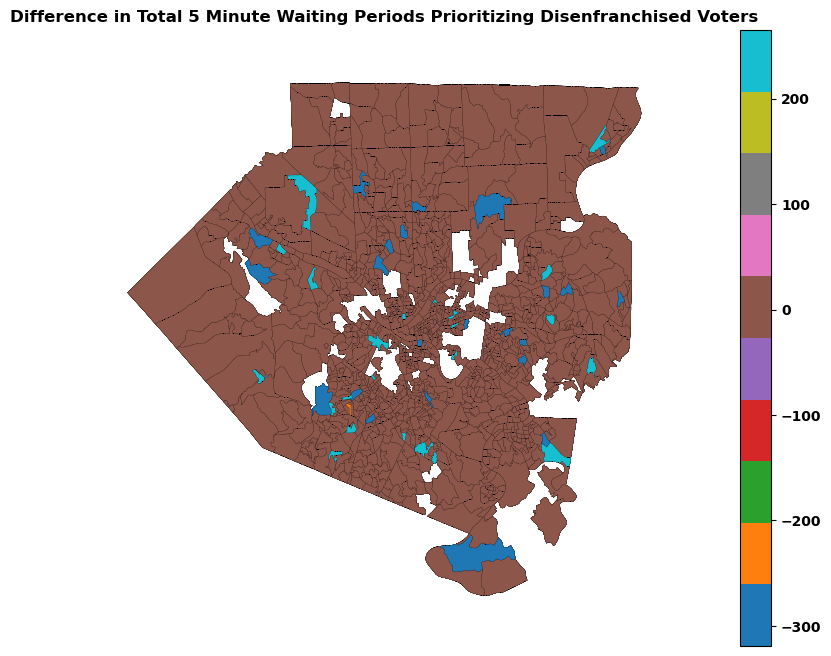

In [21]:
geo_wait_2 = geo.merge(results_2way, on = 'district', how = 'left')

gplt.choropleth(
    geo_wait_2,
    projection=gcrs.AlbersEqualArea(),
    hue="Dif Total Wait", cmap='tab10',
    linewidth=.1,
    legend = True,
    edgecolor='black',
    figsize=(12, 8)
)
plt.title('Difference in Total 5 Minute Waiting Periods Prioritizing Disenfranchised Voters')
plt.show()

# Appendix

## Two Part Optimization: Minimizing Check-in Stations and Optimizing Distribution with Priority for Historically Disenfranchised Precincts
Check-in Stations are a limiting factor for voting process time because they require additional staff and are slow to move through. In this model, first we estimate the number of check-in stations required to achieve an average expected waiting time of 5 minutes per voter and second, distribute them with a preference shown to precincts with historically disenfranchised voters.

### Check-in Station Minimization

In [ ]:
model.reset()
total_wait = 469885 # Number of expected voters
time_periods = data.columns[26:].values
num_time_periods = len(time_periods)
precinct_num = data.shape[0]

clusters = data['cluster'].values
cluster_dict = {0: 3, 1: 5, 2:3, 3:5, 4:5, 5:3}
cluster_dict2 = {0: 2, 1: 3, 2:2, 3:3, 4:3, 5:2}

arrival_rates = data.iloc[:, 26:].values

service_rate_check_in = 30/12
service_rate_voting = 60/12

total_voting_booths = precinct_num * 9

model = gp.Model("MinimizeQueueWaiting")

max_check_in_stations = 5
max_voting_booths = 10

C = model.addVars(precinct_num, vtype=GRB.INTEGER, lb=2, name="CheckInStations")
V = model.addVars(precinct_num, vtype=GRB.INTEGER, lb=3, ub=max_voting_booths, name="VotingBooths")
W_checkin = model.addVars(precinct_num, num_time_periods, vtype=GRB.INTEGER, lb=0, name="CheckInQueue")
W_voting = model.addVars(precinct_num, num_time_periods, vtype=GRB.INTEGER, lb=0, name="VotingQueue")


for i in range(precinct_num):
    service_capacity = C[i] * service_rate_check_in
    model.addConstr(
        W_checkin[i, 0] >= arrival_rates[i, 0] - service_capacity,
        name=f"InitialQueue_{i}"
    )
    model.addConstr(
        W_checkin[i, 0] >= 0,
        name=f"NonNegativeQueue_{i}_0"
    )

    model.addConstr(
        W_voting[i, 0] >= 0,
        name=f"NonNegativeVotingQueue_{i}"
    )


for i in range(precinct_num):
    for t in range(1, num_time_periods):
        service_capacity_checkin = C[i] * service_rate_check_in
        model.addConstr(
            W_checkin[i, t] >= W_checkin[i, t-1] + arrival_rates[i, t] - service_capacity_checkin,
            name=f"QueueDynamics_{i}_{t}"
        )
        model.addConstr(
            W_checkin[i, t] >= 0,
            name=f"NonNegativeQueue_{i}_{t}"
        )

        service_capacity_voting = V[i] * service_rate_voting
        model.addConstr(
            W_voting[i, t] >= W_voting[i, t-1] + (W_checkin[i,t-1]) - service_capacity_voting,
            name=f"VotingQueueDynamics_{i}_{t}"
        )
        model.addConstr(
            W_voting[i, t] >= 0,
            name=f"NonNegativeVotingQueue_{i}_{t}"
        )


model.addConstr(
    gp.quicksum(V[i] for i in range(precinct_num)) <= total_voting_booths,
    name="TotalVotingBooths"
)

model.addConstr(
    gp.quicksum(W_checkin[i, t] for i in range(precinct_num) for t in range(num_time_periods))+ \
        gp.quicksum(W_voting[i, t] for i in range(precinct_num) for t in range(num_time_periods)) <= total_wait,
        name="TotalWaitCap"
)

model.setObjective(
    gp.quicksum(C[i] for i in range(precinct_num)),
    GRB.MINIMIZE
)

model.setParam('OutputFlag', 1)
model.setParam('MIPGap', 0.01)

model.optimize()

columns = ['precinct', 'check_in', 'voting', 'checkin_stations', 'voting_stations']
prec = []
check_in = []
voting = []
checkin_stations = []
voting_stations = []

if model.status == GRB.OPTIMAL:
    print("Optimal solution found!")
    for i in range(precinct_num):
        prec.append(i)
        check_in_val = int(C[i].x)
        voting_val = int(V[i].x)
        queue_sizes_checkin = [W_checkin[i, t].x for t in range(num_time_periods)]
        queue_sizes_voting = [W_voting[i, t].x for t in range(num_time_periods)]
        check_in.append(sum(queue_sizes_checkin))
        voting.append(sum(queue_sizes_voting))
        checkin_stations.append(check_in_val)
        voting_stations.append(voting_val)
        
else:
    print("No optimal solution found. Status code:", model.status)
    if model.status == GRB.INFEASIBLE:
        print("Model is infeasible. Computing IIS (Irreducible Inconsistent Subsystem)...")
        model.computeIIS()
        model.write("model.ilp")
        print("IIS written to 'model.ilp'")

Discarded solution information
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11.0 (22631.2))

CPU model: 13th Gen Intel(R) Core(TM) i7-1360P, instruction set [SSE2|AVX|AVX2]
Thread count: 12 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 650902 rows, 328280 columns and 1788560 nonzeros
Model fingerprint: 0xc78852a3
Variable types: 0 continuous, 328280 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 5e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [2e+00, 1e+01]
  RHS range        [1e+00, 5e+05]
Found heuristic solution: objective 6373.0000000
Presolve removed 333396 rows and 8160 columns
Presolve time: 2.33s
Presolved: 317506 rows, 320120 columns, 1427510 nonzeros
Variable types: 0 continuous, 320120 integer (0 binary)
Deterministic concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Root barrier log...

Ordering time:

#### Total Check-in Stations Required

In [23]:
print(model.objVal)
opt_max_checkin_stations = model.objVal

2999.0


### Check-In Station Distribution Optimization

In [ ]:
model.reset()
total_wait = 469885
time_periods = data.columns[26:].values
num_time_periods = len(time_periods)
precinct_num = data.shape[0]

clusters = data['cluster'].values
cluster_dict = {0: 3, 1: 5, 2:3, 3:5, 4:5, 5:3}
cluster_dict2 = {0: 2, 1: 3, 2:2, 3:3, 4:3, 5:2}

arrival_rates = data.iloc[:, 26:].values

service_rate_check_in = 30/12
service_rate_voting = 60/12

total_check_in_stations = opt_max_checkin_stations
total_voting_booths = precinct_num * 9

model = gp.Model("MinimizeQueueWaiting")

max_check_in_stations = 5
max_voting_booths = 10


C = model.addVars(precinct_num, vtype=GRB.INTEGER, lb=2, name="CheckInStations")
V = model.addVars(precinct_num, vtype=GRB.INTEGER, lb=3, ub=max_voting_booths, name="VotingBooths")
W_checkin = model.addVars(precinct_num, num_time_periods, vtype=GRB.INTEGER, lb=0, name="CheckInQueue")
W_voting = model.addVars(precinct_num, num_time_periods, vtype=GRB.INTEGER, lb=0, name="VotingQueue")

for i in range(precinct_num):
    service_capacity = C[i] * service_rate_check_in
    model.addConstr(
        W_checkin[i, 0] >= arrival_rates[i, 0] - service_capacity,
        name=f"InitialQueue_{i}"
    )
    model.addConstr(
        W_checkin[i, 0] >= 0,
        name=f"NonNegativeQueue_{i}_0"
    )

    model.addConstr(
        W_voting[i, 0] >= 0,
        name=f"NonNegativeVotingQueue_{i}"
    )

    min_checkin_station = cluster_dict2[clusters[i]]
    model.addConstr(
        V[i] >= min_checkin_station,
        name=f"MinVotingBooths_{i}"
    )
    
    min_booth_voting = cluster_dict[clusters[i]]
    model.addConstr(
        V[i] >= min_booth_voting,
        name=f"MinVotingBooths_{i}"
    )


for i in range(precinct_num):
    for t in range(1, num_time_periods):
        service_capacity_checkin = C[i] * service_rate_check_in
        model.addConstr(
            W_checkin[i, t] >= W_checkin[i, t-1] + arrival_rates[i, t] - service_capacity_checkin,
            name=f"QueueDynamics_{i}_{t}"
        )
        model.addConstr(
            W_checkin[i, t] >= 0,
            name=f"NonNegativeQueue_{i}_{t}"
        )

        service_capacity_voting = V[i] * service_rate_voting
        model.addConstr(
            W_voting[i, t] >= W_voting[i, t-1] + (W_checkin[i,t-1]) - service_capacity_voting,
            name=f"VotingQueueDynamics_{i}_{t}"
        )
        model.addConstr(
            W_voting[i, t] >= 0,
            name=f"NonNegativeVotingQueue_{i}_{t}"
        )

model.addConstr(
    gp.quicksum(C[i] for i in range(precinct_num)) <= total_check_in_stations,
    name="TotalCheckInStations"
)
model.addConstr(
    gp.quicksum(V[i] for i in range(precinct_num)) <= total_voting_booths,
    name="TotalVotingBooths"
)


model.setObjective(
    gp.quicksum(W_checkin[i, t] for i in range(precinct_num) for t in range(num_time_periods))+ \
        gp.quicksum(W_voting[i, t] for i in range(precinct_num) for t in range(num_time_periods)),
    GRB.MINIMIZE
)

model.setParam('OutputFlag', 1)
model.setParam('MIPGap', 0.01)

model.optimize()

columns = ['precinct', 'check_in', 'voting', 'checkin_stations', 'voting_stations']
prec = []
check_in = []
voting = []
checkin_stations = []
voting_stations = []

if model.status == GRB.OPTIMAL:
    print("Optimal solution found!")
    for i in range(precinct_num):
        prec.append(i)
        check_in_val = int(C[i].x)
        voting_val = int(V[i].x)
        queue_sizes_checkin = [W_checkin[i, t].x for t in range(num_time_periods)]
        queue_sizes_voting = [W_voting[i, t].x for t in range(num_time_periods)]
        check_in.append(sum(queue_sizes_checkin))
        voting.append(sum(queue_sizes_voting))
        checkin_stations.append(check_in_val)
        voting_stations.append(voting_val)
        
        # print(f"Precinct {i}: {check_in} check-in stations, {voting} voting booths")
        # print(f"Check-in Queue sizes per time period: {queue_sizes_checkin}")
        # print(f"Voting queue sizes per time period: {queue_sizes_voting}")
        # print("Queue check-in:", sum(queue_sizes_checkin))
        # print("Queue voting:", sum(queue_sizes_voting)+sum(queue_sizes_checkin))
        # print("Average Queue:", np.mean(queue_sizes_checkin), np.mean(queue_sizes_voting))
else:
    print("No optimal solution found. Status code:", model.status)
    if model.status == GRB.INFEASIBLE:
        print("Model is infeasible. Computing IIS (Irreducible Inconsistent Subsystem)...")
        model.computeIIS()
        model.write("model.ilp")
        print("IIS written to 'model.ilp'")

Discarded solution information
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11.0 (22631.2))

CPU model: 13th Gen Intel(R) Core(TM) i7-1360P, instruction set [SSE2|AVX|AVX2]
Thread count: 12 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 653166 rows, 328280 columns and 1465940 nonzeros
Model fingerprint: 0x9b2103a4
Variable types: 0 continuous, 328280 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 5e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [2e+00, 1e+01]
  RHS range        [1e+00, 1e+04]
Presolve removed 572174 rows and 245967 columns
Presolve time: 0.77s
Presolved: 80992 rows, 82313 columns, 232635 nonzeros
Variable types: 0 continuous, 82313 integer (2509 binary)
Deterministic concurrent LP optimizer: primal and dual simplex
Showing primal log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root relaxation: objective 4.317290e+05, 34187 

#### Total Expected Waiting Periods

In [25]:
model.objVal

463918.0

### 2 Stage Model Results

In [26]:
results_d = pd.DataFrame({'prec': prec,
              'check_in': check_in,
                'voting':voting,
                "checkin_stations": checkin_stations,
                "voting_stations": voting_stations})
results_d['district'] = data['district']
results_d['cluster'] = data['cluster']
results_d['total wait'] = results_d['check_in'] + results_d['voting']

In [27]:
print("Total Waiting Periods: ", model.objVal, 
        "\nAverage Expected Waiting Time: ", (model.objVal/469885)*5,
        "\nAverage Expected Waiting Time (Priority Clusters): ", ((results_d[((results_d['cluster'] == 1) | (results_d['cluster'] == 3) | (results_d['cluster'] == 4))]['total wait'].sum())/(data[(data['cluster'] == 1) | (data['cluster'] == 3) | (data['cluster'] == 4)].iloc[:,26:].sum().sum()))*5
)

Total Waiting Periods:  463918.0 
Average Expected Waiting Time:  4.936505740766358 
Average Expected Waiting Time (Priority Clusters):  4.348016494333948
